In [15]:
import numpy as np
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import sem
import seaborn as sns
import pickle

In [2]:
def binarize(traces):
    stds = np.std(traces,axis=-1)
    out = np.zeros_like(traces)
    for i in range(traces.shape[0]):
        for j in range(traces.shape[1]):
            if traces[i,j]>stds[i]:
                out[i][j] = 1
            else:
                out[i][j] = 0

    return out


def BIC(ll,k,n):
    return k*np.log(n) + 2*ll


In [25]:
data = np.load('../../../data/raw_data/nike_calcium_trace.npy')
X = binarize(data).T
Xt = data.T
with open('../../../data/raw_data/behaviour.pickle','rb') as f:
    behaviour = pickle.load(f)

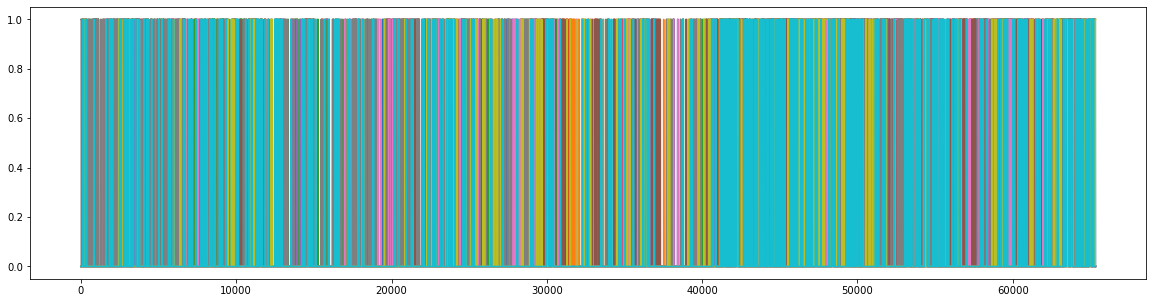

In [26]:
plt.figure(figsize=(20,5))
for i in range(10):
    plt.plot(X[:,i])

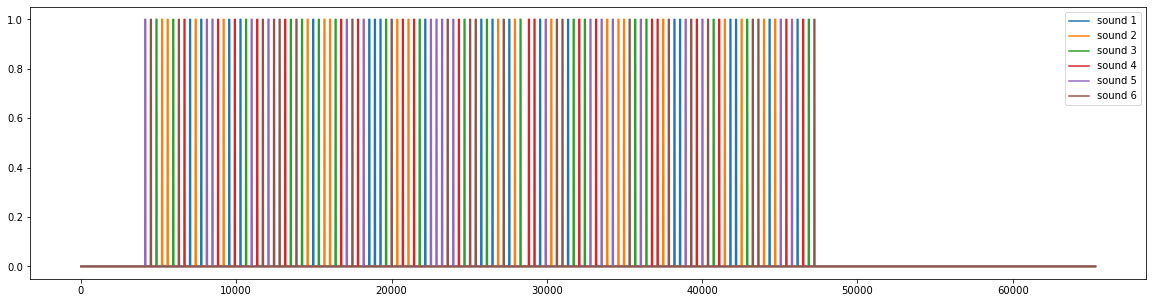

In [5]:
stimulus_duration = 60 # in indexes
stimuli = [1,2,3,4,5,6]

plt.figure(figsize=(20,5))
y = np.zeros(X.shape[0])
for s in stimuli:
    stim_mask = np.zeros(X.shape[0])
    for onset in behaviour[f'sound{s}']:
        stim_mask[onset:onset+stimulus_duration] = 1
        y[onset:onset+stimulus_duration] = s
    plt.plot(stim_mask,label=f'sound {s}')

plt.legend()

## Stimulus classification using RBMs

In [8]:
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import f1_score


In [27]:
logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm = BernoulliRBM(random_state=0, verbose=False)
rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])

# Hyper-parameters. To be set by cross-validation, using a GridSearchCV.
rbm.learning_rate = 0.06
rbm.n_iter = 10
rbm.n_components = 15
logistic.C = 6000
n_splits = 10

kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
performance = []
lr_performance = []
shuffled_performance = []
for i,(train_index, test_index) in enumerate(kf.split(X,y)):
    print(f'fold {i+1}/{n_splits}')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # RBM classifier
    rbm_split = clone(rbm_features_classifier)
    rbm_split.fit(X_train, y_train)

    y_pred = rbm_split.predict(X_test)
    performance.append(f1_score(y_test,y_pred,average='weighted'))

    # linear baseline
    linear_clf_split = clone(logistic)
    linear_clf_split.fit(X_train, y_train)
    y_pred = linear_clf_split.predict(X_test)
    lr_performance.append(f1_score(y_test,y_pred,average='weighted'))
    

    # shuffled baseline
    shuffled_performance.append(f1_score(y_test,np.random.permutation(y_test),average='weighted'))

fold 1/10
fold 2/10
fold 3/10
fold 4/10
fold 5/10
fold 6/10
fold 7/10
fold 8/10
fold 9/10
fold 10/10


<AxesSubplot:>

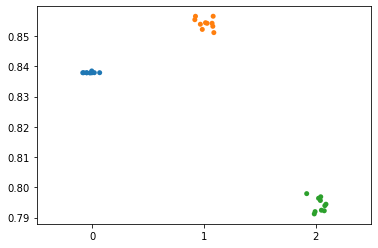

In [28]:
sns.stripplot(data=[performance,lr_performance,shuffled_performance])

## Results
- Performance is larger than chance (calculated by shuffling labels per fold): we can decode stimulus identity
- Linear model better than RBM + linear: maybe is the parameters regime, a grid search could be useful

## TO DO
- Grid search for RBM (and linear) model
- Try 2 layer perceptron instead?
- Look at stimulus dependent component, can we have the spatial arrangement of neurons?